# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [1]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

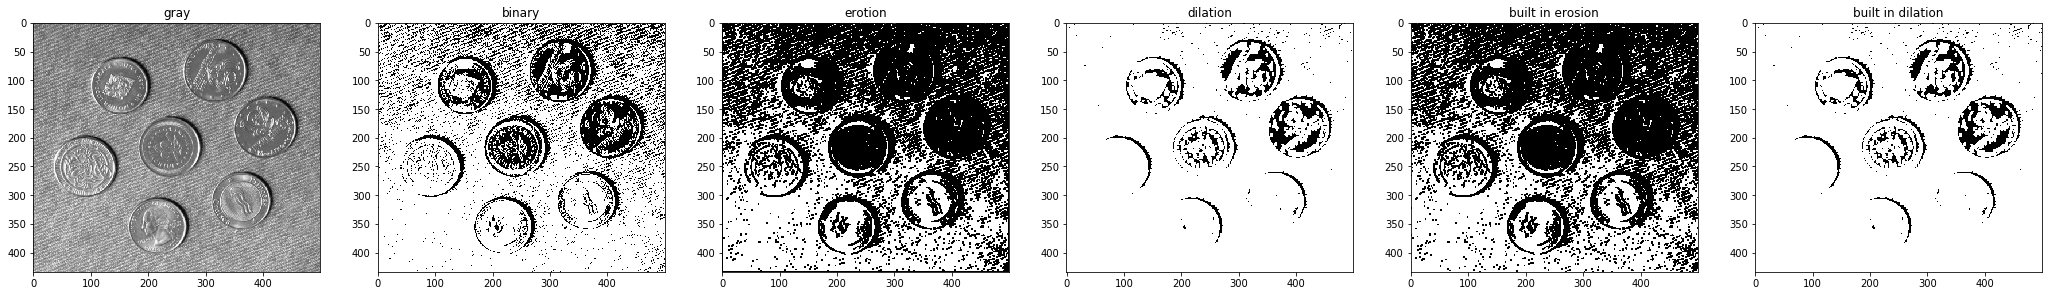

In [3]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''
img = io.imread('img/coins.jpg')
img = rgb2gray(img)
binary = 1.0 * (img > 0.5)
def erosion(img,size1,size2):
    output_image = np.zeros(img.shape)
    erosion_filter = np.ones((size1,size2)) #could be adjusted to fulfil any structuring element
    sz1 = int(size1/2)
    sz2 = int(size2/2)
    for i in range(sz1,img.shape[0]-sz1+(size1%2==0)):
        for j in range(sz2,img.shape[1]-sz2+(size2%2==0)):
            val = 1
            for k in range(i-sz1,i+sz1+size1%2):
                for s in range(j-sz2,j+sz2+size2%2):
                    val&=(img[k][s]==erosion_filter[k-(i-sz1)][s-(j-sz2)])
            output_image[i][j]=val
    return output_image
def dilation(img,size1,size2):
    output_image = np.ones(img.shape)
    dilation_filter = np.ones((size1,size2)) #could be adjusted to fulfil any structuring element
    sz1 = int(size1/2)
    sz2 = int(size2/2)
    for i in range(sz1,img.shape[0]-sz1+(size1%2==0)):
        for j in range(sz2,img.shape[1]-sz2+(size2%2==0)):
            val = 0
            for k in range(i-sz1,i+sz1+size1%2):
                for s in range(j-sz2,j+sz2+size2%2):
                    val|=(img[k][s]==dilation_filter[k-(i-sz1)][s-(j-sz2)])
            output_image[i][j]=val
    return output_image
size1 = 3
size2 = 3
ED_filter = np.ones((size1,size2))
eroted = erosion(binary,size1,size2)
dilated = dilation(binary,size1,size2)
eroted2=binary_erosion(binary,ED_filter)
dilated2=binary_dilation(binary,ED_filter)
show_images([img,binary,eroted,dilated,eroted2,dilated2],["gray","binary","erotion","dilation","built in erosion","built in dilation"])

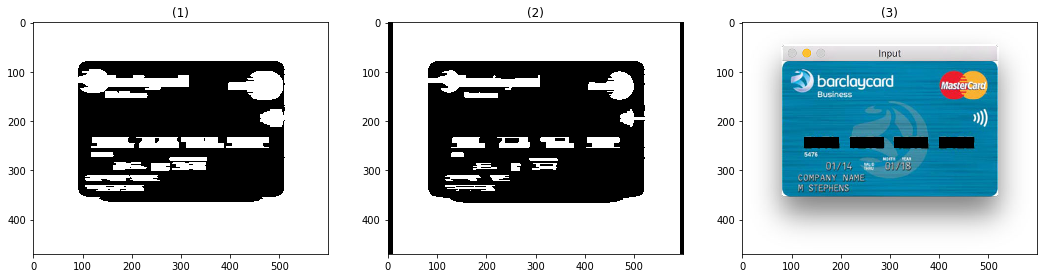

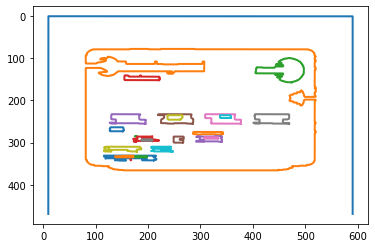

In [4]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''
from skimage import measure
from skimage.draw import polygon, polygon_perimeter
card=io.imread("img/card.jpg")
with_boxes=np.copy(card)
card=rgb2gray(card)
img_gray=np.copy(card)*256
threshold=0.6
card[card[:,:]>threshold]=1
card[card[:,:]<=threshold]=0   
dilated_image=dilation(card,2,20)
eroded_image=erosion(dilated_image,2,20)      
contours=measure.find_contours(eroded_image,0.8)
i=0
for contour in contours:
    bounding_boxes=[]
    Xmin = np.min(contour[:,1])
    Xmax = np.max(contour[:,1])
    Ymin = np.min(contour[:,0])
    Ymax = np.max(contour[:,0])
    width=Xmax-Xmin
    hight=Ymax-Ymin
    ar=width/float(hight)
    if ar > 2.5 and ar < 3.5:
        if (hight > 20 and hight < 25):
            bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
            border=np.array(bounding_boxes[0],dtype='int')
            for box in bounding_boxes:
                [Xmin, Xmax, Ymin, Ymax] = bounding_boxes[0]
                rr, cc =rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img_gray.shape)
                rr=np.array(rr,dtype='int')
                cc=np.array(cc,dtype='int')
                with_boxes[rr, cc] =0 #set color white
show_images([dilated_image,eroded_image,with_boxes])
plt.gca().invert_yaxis()
for n,contour in enumerate(contours):
    plt.plot(contour[:,1], contour[:, 0], linewidth=2)        

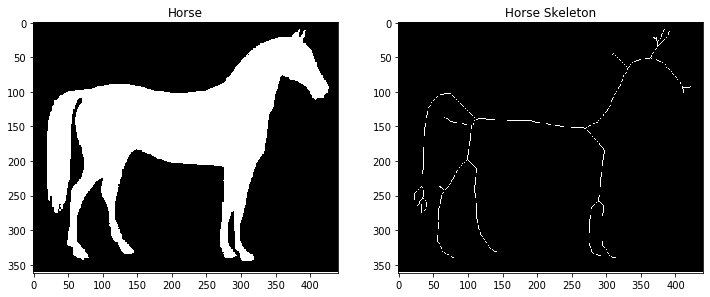

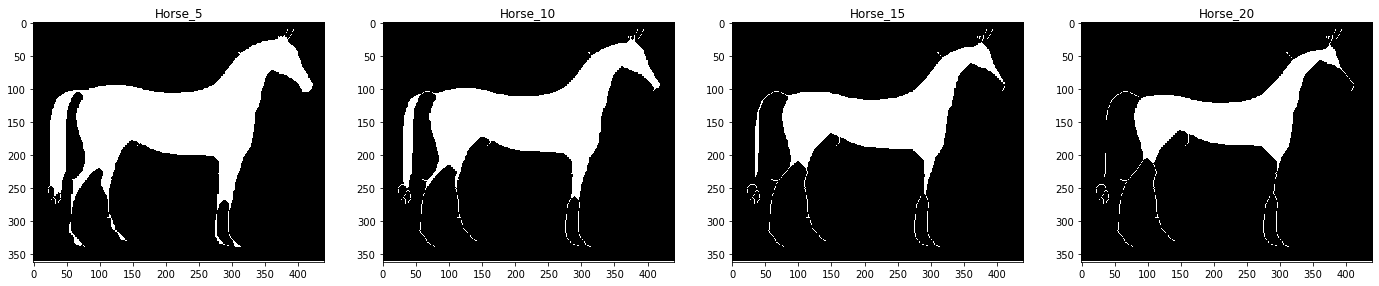

In [5]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
horse=io.imread("img/horse.jpg")
horse=rgb2gray(horse)
threshold=0.91
horse[horse[:,:]<=threshold]=0
horse[horse[:,:]>threshold]=1
horse_skeleton=skeletonize(horse)
show_images([horse,horse_skeleton],["Horse","Horse Skeleton"])
horse_thin_5,horse_thin_10,horse_thin_15,horse_thin_20=thin(horse,5),thin(horse,10),thin(horse,15),thin(horse,20)
show_images([horse_thin_5,horse_thin_10,horse_thin_15,horse_thin_20],["Horse_5","Horse_10","Horse_15","Horse_20"])